### Ch 9: Decision Analysis

#### The Price is Right Problem

The showcase must consider a few things:

- Before seeing prizes what prior beliefs should contestants have about the price of the showcase?
- After seeing the pirzes, how should contestants update beliefs?
- Based on the posterior distribution, what should contestants bid? (**decision analysis**)

#### The Prior: 

Author downloaded files containing price of each showcase from 2011 and 2012 seasons and bids made. 

In [11]:
import pandas as pd

showcase_2011 = 'https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2011.csv'
showcase_2012 = 'https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2012.csv'

def read_data(filename):
    """Read the showcase price data."""
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

df2011 = read_data(showcase_2011)
df2012 = read_data(showcase_2012)

df = pd.concat([df2011, df2012], ignore_index=True)
df.head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
3,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
4,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


#### Kernel Density Estimation

- KDE is going to use a sample to estimate a smooth distribution

- Fantastic overview of KDE: https://mathisonian.github.io/kde/

Why use KDE?
- Can visualize the "shape" of data, KDE can be thought of as a continuous replacement for the discrete histogram
- Can generate points that look like they come from a specific dataset

Details:
- `bandwidth` parameter affects how smooth the resulting curve is 
    - really low values will be "squiggly" & complex, fitting more points
    - higher values will be smoother & less complex, less variation but worse overall mapping (better generalization I assume)
    
- bandwidth is going to control how many data points are used in a specific location to map an estimate of the function
    - lower bandwidth is going to look at points very near the position (squiggly)
    - higher bandwidth is going to mean a shallow kernel where points much further out contribute
    
Equation:

$f(x) = \sum_{obs} K * \frac{x - obs}{bandwidth}$

where K represents a specific kernel function, such as `normal`, `uniform`, `triangular`, etc. 

#### KDE As A Prior

- we can use scipy's `gaussian_kde` which takes a sample and returns an object that represents the estimated distribution. 

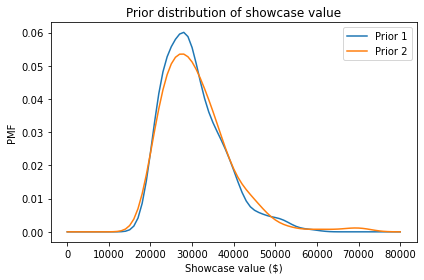

In [13]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf
import numpy as np
import matplotlib.pyplot as plt

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()
    

def kde_from_sample(sample, qs):
    """Make a kernel density estimate from a sample."""
    kde = gaussian_kde(sample) # build KDE from sample
    ps = kde(qs) # get probabilities for each quantity off of the KDE
    pmf = Pmf(ps, qs) # convert to a Pmf
    pmf.normalize()
    return pmf

# estimate distributiojn of showcase 1:
qs = np.linspace(0, 80000, 81)
prior1 = kde_from_sample(df['Showcase 1'], qs)

def decorate_value(title=''):
    decorate(xlabel='Showcase value ($)',
        ylabel='PMF',
        title=title)

# build showcase 2:
prior2 = kde_from_sample(df['Showcase 2'], qs)

prior1.plot(label='Prior 1')
prior2.plot(label='Prior 2')
decorate_value('Prior distribution of showcase value')

#### Main Takeaway:

- Use historical data & leverage KDE to build an approximation of this as a Pmf, which can be used as a prior.

#### Distribution of Error:

Above we have a prior for showcase value. But we still must answe:
- What data should we consider?
- Can we compute a likelihood function? E.g. For each hypothetical price, can we compute the conditional likelihood of the data? 

Author's logic: 
- Each contestant is a price-guessing instrument with known error characteristics. 
- A contestant sees the prizes, guesses the price of each pize and adds up the prices for a total guess. 
- We must answer: "If the actual price is `X`, what is the likelihood the contestant would guess `Y`?"
    - We can rethink this in terms of error, where `error = guess (Y) - price (X)`
    - Now we say "What is the likelihood that the contentant's guess is off by `error`?"

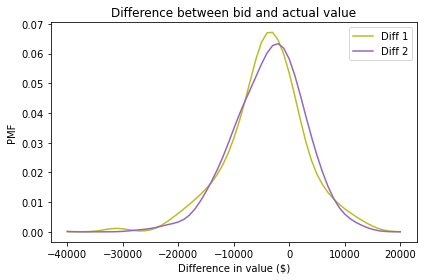

In [14]:
# find error over two years
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']

# use KDe to estimate continuous function
qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

# plot
kde_diff1.plot(label='Diff 1', color='C8')
kde_diff2.plot(label='Diff 2', color='C4')

decorate(xlabel='Difference in value ($)',
        ylabel='PMF',
        title='Difference between bid and actual value')

#### Basic Findings:

- Bids are too low more often than too high
    - Likely since an overbid is an automatic loss 
- KDEs look very similar to normal distribution, so can summarize mean & st. dev

In [15]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()

print(mean_diff1, std_diff1)

-4116.3961661341855 6899.909806377117


#### Interesting Assumption:

- Author assumes contestants under to be strategic, but otherwise would have an accurate guest with 0 error. 
    - I really don't follow why this has to happen? Why not just build using the negative value above?
- Author assumes spread of differences reflects the actual spread of errors

In [18]:
from scipy.stats import norm

error_dist1 = norm(0, std_diff1)

# prob density of error = - 100
error = -100
error_dist1.pdf(error)

5.781240564008691e-05

#### A Comment on Probability Densities:

- These are not probabilities. However, they are proportional to probabilities so we can use them as likelihoods. 

- A probability density is not a probability, rather it is going to help us capture the density around a point x. And we do this over some very small interval $I_{x}$

### Update: 

Assume we guess `$23000`

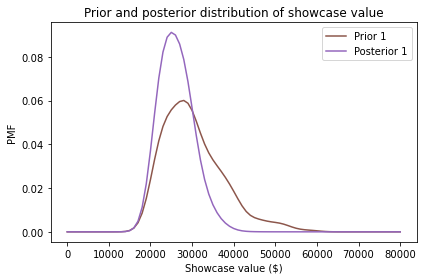

In [24]:
guess1 = 23000

# error relative to all hypothetical prices in prior
error1 = guess1 - prior1.qs

# we can also compute likelihood of error based on the calculation above
likelihood1 = error_dist1.pdf(error1)

# and the update:
posterior1 = prior1 * likelihood1
posterior1.normalize()

# plot:
prior1.plot(color='C5', label='Prior 1')
posterior1.plot(color='C4', label='Posterior 1')

decorate_value('Prior and posterior distribution of showcase value')

In [25]:
prior1.mean(), posterior1.mean()

(30299.488817891375, 26192.024002392536)

#### Takeaways:

- Before seeing prizes & only knowing prior info the expected value was close to 30K. 
- After making a guess of 23K we now expect actual price to be about 26K. 
    - I don't find this intuitive. 

-3675.891373801917 6886.260711323408
31047.623719122505 34305.20161642469


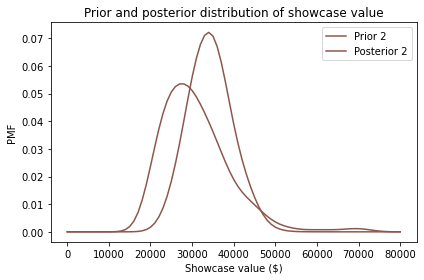

In [27]:
# Handling for Player 2: 
mean_diff2 = sample_diff2.mean()
std_diff2 = sample_diff2.std()

print(mean_diff2, std_diff2)

error_dist2 = norm(0, std_diff2) # still confused

# Larger guess
guess2 = 38000
error2 = guess2 - prior2.qs

likelihood2 = error_dist2.pdf(error2)

# update
posterior2 = prior2 * likelihood2
posterior2.normalize()

# plot

prior2.plot(color='C5', label='Prior 2')
posterior2.plot(color='C15', label='Posterior 2')

decorate_value('Prior and posterior distribution of showcase value')

print(prior2.mean(), posterior2.mean())


### Probability of Winning: 

P1 considers the following: 
- probability P2 overbids
- probability that P2 underbids > P1

Important note:
- When looking from P1 perspective we are assuming that P2 (our competitor) can be explained by the history of Showcase 2 data. 

In [28]:
def prob_overbid(sample_diff):
    """Compute the probability of an overbid."""
    return np.mean(sample_diff > 0)

# Estimate of overbid for p2 using historical data
prob_overbid(sample_diff2)

0.29073482428115016

In [29]:
def prob_worse_than(diff, sample_diff):
    """Probability opponent diff is worse than given diff."""
    return np.mean(sample_diff < diff)

# prob that P2 underbids by more than 5K (which is what P1 underbids by)
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

In [32]:
# Combine to determine likelihood of winning based on a difference:
def compute_prob_win(diff, sample_diff):
    """Probability of winning for a given diff.
    
    Note: p1 & p2 just indicate probabilities, they don't
    represent player1 or player 2.
    
    """
    # if you overbid you lose
    if diff > 0:
        return 0
    
    # if the opponent overbids, you win
    p1 = prob_overbid(sample_diff)
    
    # or of their bid is worse than yours, you win
    p2 = prob_worse_than(diff, sample_diff)
    
    # p1 and p2 are mutually exclusive, so we can add them
    return p1 + p2

# likelihood that p1 wins if they unerbid by 5K
# Note: all of this is based on prior history 
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

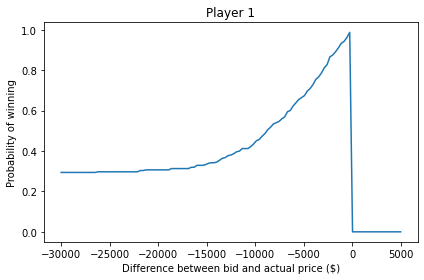

In [35]:
import matplotlib.pyplot as plt

# probability of winning over a range of differences:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) 
      for x in xs]

# plot
plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 1')

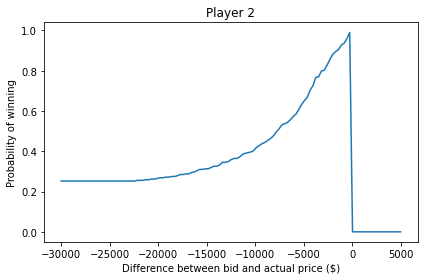

In [36]:
# P2 perspective: compared to P1
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff1) for x in xs]

plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 2')

#### Decision Analysis: 

